In [ ]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import torch
from tensorflow import random as tf_random # Import random module and alias it
from numpy.random import seed
tf_random.set_seed(1) # Use the function from the imported module
seed(1)

In [ ]:
# ⚙️ Check GPU Availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ GPU is available!")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("❌ GPU not available, using CPU.")
print(f"Current device: {device}")

❌ GPU not available, using CPU.
Current device: cpu


In [ ]:
# 🔧 Hyperparameters
window_size = 30
batch_size = 256
learning_rate = 0.0003
epochs = 300

In [ ]:
dataset_path = "/content/train.csv"
train = pd.read_csv(dataset_path, parse_dates=['date'])
train = train[(train['date'] >= '2017-01-01')]
train

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
train_gp = train.sort_values('date').groupby([ 'date', 'store','item'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['date', 'store','item', 'sales']
train_gp['item'] = train_gp['item'].astype('category')
train_gp['store'] = train_gp['store'].astype('category')
train_gp['dayofweek'] = train_gp['date'].dt.dayofweek
train_gp['weekend'] = train_gp['dayofweek'].isin([5, 6]).astype(int)
train_gp['month'] = train_gp['date'].dt.month
train_gp['day'] = train_gp['date'].dt.day
train_gp['sale90'] = train_gp.groupby(['store','item'])['sales'].shift(-90)
train_gp = train_gp.dropna()
train_gp.head()

<ipython-input-5-f10b03b514f8>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_gp['sale90'] = train_gp.groupby(['store','item'])['sales'].shift(-90)


,date,store,item,sales,dayofweek,weekend,month,day,sale90
0,2017-01-01,1,1,19.0,6,1,1,1,26.0
1,2017-01-01,1,2,40.0,6,1,1,1,61.0
2,2017-01-01,1,3,36.0,6,1,1,1,40.0
3,2017-01-01,1,4,21.0,6,1,1,1,37.0
4,2017-01-01,1,5,25.0,6,1,1,1,26.0


In [ ]:
feature_cols = ['sales','store', 'item', 'dayofweek', 'weekend', 'month', 'day']
targets = 'sale90'

train = train_gp[train_gp['date'] < '2017-7-1']
valid = train_gp[(train_gp['date'] >= '2017-7-1') & (train_gp['date'] < '2017-9-1')]
test = train_gp[train_gp['date'] >= '2017-9-1']

train = train.set_index('date')
valid = valid.set_index('date')
test = test.set_index('date')


features_train = train[feature_cols].values
target_train = train[targets].values

features_valid = valid[feature_cols].values
target_valid = valid[targets].values

features_test = test[feature_cols].values
target_test = test[targets].values

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

X_seq_train, y_seq_train = create_sequences(features_train, target_train, window_size)
X_seq_valid, y_seq_valid = create_sequences(features_valid, target_valid, window_size)
X_seq_test, y_seq_test = create_sequences(features_test, target_test, window_size)

X_train, y_train = X_seq_train, y_seq_train
X_valid, y_valid = X_seq_valid, y_seq_valid
X_test, y_test = X_seq_test, y_seq_test

In [ ]:
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_valid shape : ",X_valid.shape)
print("y_valid shape : ",y_valid.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (90470, 30, 7)
y_train shape :  (90470,)
X_valid shape :  (30970, 30, 7)
y_valid shape :  (30970,)
X_test shape :  (15970, 30, 7)
y_test shape :  (15970,)


In [ ]:
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
# 🧠 Build LSTM Model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

# กำหนด learning rate ใหม่
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mse'])

# ⏹ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# 🔁 Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

Epoch 1/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4576.4272 - mse: 4576.4272

354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4573.5474 - mse: 4573.5474 - val_loss: 2615.1448 - val_mse: 2615.1448
Epoch 2/300
350/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3376.5518 - mse: 3376.5518

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3374.3320 - mse: 3374.3320 - val_loss: 2118.2620 - val_mse: 2118.2620
Epoch 3/300
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2816.6711 - mse: 2816.6711

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2815.6167 - mse: 2815.6167 - val_loss: 1738.4583 - val_mse: 1738.4583
Epoch 4/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2375.1558 - mse: 2375.1558

354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2374.8770 - mse: 2374.8770 - val_loss: 1449.9672 - val_mse: 1449.9672
Epoch 5/300
350/354 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2028.7484 - mse: 2028.7484

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2027.6292 - mse: 2027.6292 - val_loss: 1237.1501 - val_mse: 1237.1501
Epoch 6/300
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1759.4690 - mse: 1759.4690

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1758.9515 - mse: 1758.9515 - val_loss: 1087.1033 - val_mse: 1087.1033
Epoch 7/300
350/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1557.1940 - mse: 1557.1940

354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1556.5292 - mse: 1556.5292 - val_loss: 988.4520 - val_mse: 988.4520
Epoch 8/300
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1410.9927 - mse: 1410.9927

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1410.4124 - mse: 1410.4124 - val_loss: 930.5186 - val_mse: 930.5186
Epoch 9/300
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1307.3728 - mse: 1307.3728

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1306.9257 - mse: 1306.9257 - val_loss: 903.2004 - val_mse: 903.2004
Epoch 10/300
351/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1240.5314 - mse: 1240.5314

354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1240.3258 - mse: 1240.3258 - val_loss: 897.0045 - val_mse: 897.0045
Epoch 11/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1201.3303 - mse: 1201.3303 - val_loss: 903.3611 - val_mse: 903.3611
Epoch 12/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1177.0159 - mse: 1177.0159 - val_loss: 915.1279 - val_mse: 915.1279
Epoch 13/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 1166.5594 - mse: 1166.5594 - val_loss: 927.0532 - val_mse: 927.0532
Epoch 14/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 1161.0864 - mse: 1161.0864 - val_loss: 936.3624 - val_mse: 936.3624
Epoch 15/300
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1116.6943 - mse: 1116.6943 

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1115.7184 - mse: 1115.7184 - val_loss: 704.8013 - val_mse: 704.8013
Epoch 16/300
348/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 916.0840 - mse: 916.0840

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 915.1544 - mse: 915.1544 - val_loss: 608.6791 - val_mse: 608.6791
Epoch 17/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 780.8604 - mse: 780.8604

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 780.7009 - mse: 780.7009 - val_loss: 546.6605 - val_mse: 546.6605
Epoch 18/300
351/354 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 678.2646 - mse: 678.2646

354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 677.9329 - mse: 677.9329 - val_loss: 475.5825 - val_mse: 475.5825
Epoch 19/300
348/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 569.5493 - mse: 569.5493

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 568.9118 - mse: 568.9118 - val_loss: 388.2210 - val_mse: 388.2210
Epoch 20/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 460.8643 - mse: 460.8643

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 460.8006 - mse: 460.8006 - val_loss: 313.2552 - val_mse: 313.2552
Epoch 21/300
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 391.2715 - mse: 391.2715

354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 390.9928 - mse: 390.9928 - val_loss: 305.2016 - val_mse: 305.2016
Epoch 22/300
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.4812 - mse: 341.4812

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 341.2761 - mse: 341.2761 - val_loss: 262.8610 - val_mse: 262.8610
Epoch 23/300
350/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 304.5772 - mse: 304.5772

354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 304.4294 - mse: 304.4294 - val_loss: 256.3958 - val_mse: 256.3958
Epoch 24/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 277.7173 - mse: 277.7173 - val_loss: 280.8778 - val_mse: 280.8778
Epoch 25/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 255.5862 - mse: 255.5862 - val_loss: 260.6986 - val_mse: 260.6986
Epoch 26/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 234.7576 - mse: 234.7576

354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 234.7393 - mse: 234.7393 - val_loss: 227.7901 - val_mse: 227.7901
Epoch 27/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 222.8442 - mse: 222.8442 - val_loss: 252.8642 - val_mse: 252.8642
Epoch 28/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 210.7744 - mse: 210.7744 - val_loss: 236.5144 - val_mse: 236.5144
Epoch 29/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 199.2015 - mse: 199.2015 

354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 199.1776 - mse: 199.1776 - val_loss: 218.4724 - val_mse: 218.4724
Epoch 30/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 190.7319 - mse: 190.7319 - val_loss: 219.6072 - val_mse: 219.6072
Epoch 31/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 186.2896 - mse: 186.2896

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 186.2764 - mse: 186.2764 - val_loss: 216.1009 - val_mse: 216.1009
Epoch 32/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 176.6782 - mse: 176.6782 - val_loss: 240.8846 - val_mse: 240.8846
Epoch 33/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 171.7805 - mse: 171.7805 - val_loss: 220.1705 - val_mse: 220.1705
Epoch 34/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 165.4649 - mse: 165.4649 - val_loss: 227.6939 - val_mse: 227.6939
Epoch 35/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 160.8335 - mse: 160.8335 - val_loss: 226.9660 - val_mse: 226.9660
Epoch 36/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 157.8851 - mse: 157.8851 - val_loss: 216.6619 - val_mse: 216.6619
Epoch 37/300
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 154.3630 - mse: 154.3630

354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 154.3783 - mse: 154.3783 - val_loss: 214.5275 - val_mse: 214.5275
Epoch 38/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 154.6540 - mse: 154.6540 - val_loss: 219.7160 - val_mse: 219.7160
Epoch 39/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 149.0795 - mse: 149.0795

354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 149.0770 - mse: 149.0770 - val_loss: 203.7192 - val_mse: 203.7192
Epoch 40/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 144.1500 - mse: 144.1500 - val_loss: 219.6340 - val_mse: 219.6340
Epoch 41/300
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 145.6535 - mse: 145.6535

354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 145.6311 - mse: 145.6311 - val_loss: 191.1245 - val_mse: 191.1245
Epoch 42/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 139.5998 - mse: 139.5998 - val_loss: 201.4708 - val_mse: 201.4708
Epoch 43/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 138.1066 - mse: 138.1066 - val_loss: 212.2390 - val_mse: 212.2390
Epoch 44/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 138.4781 - mse: 138.4781 - val_loss: 194.3855 - val_mse: 194.3855
Epoch 45/300
351/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 137.7889 - mse: 137.7889 

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 137.7845 - mse: 137.7845 - val_loss: 187.9306 - val_mse: 187.9306
Epoch 46/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 134.0460 - mse: 134.0460 - val_loss: 202.3957 - val_mse: 202.3957
Epoch 47/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 130.6907 - mse: 130.6907 - val_loss: 198.1837 - val_mse: 198.1837
Epoch 48/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 129.7767 - mse: 129.7767 - val_loss: 192.5771 - val_mse: 192.5771
Epoch 49/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 129.5648 - mse: 129.5648

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 129.5639 - mse: 129.5639 - val_loss: 178.5079 - val_mse: 178.5079
Epoch 50/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 128.6991 - mse: 128.6991 - val_loss: 185.3650 - val_mse: 185.3650
Epoch 51/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 126.9163 - mse: 126.9163 - val_loss: 192.7423 - val_mse: 192.7423
Epoch 52/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 127.4099 - mse: 127.4099 - val_loss: 184.5934 - val_mse: 184.5934
Epoch 53/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 125.1655 - mse: 125.1655

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 125.1684 - mse: 125.1684 - val_loss: 177.0674 - val_mse: 177.0674
Epoch 54/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 124.7250 - mse: 124.7250

354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 124.7255 - mse: 124.7255 - val_loss: 171.9352 - val_mse: 171.9352
Epoch 55/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 125.3337 - mse: 125.3337 - val_loss: 191.1209 - val_mse: 191.1209
Epoch 56/300
351/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 122.4080 - mse: 122.4080

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 122.4100 - mse: 122.4100 - val_loss: 163.6907 - val_mse: 163.6907
Epoch 57/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 121.6601 - mse: 121.6601 - val_loss: 183.2293 - val_mse: 183.2293
Epoch 58/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 121.0242 - mse: 121.0242 - val_loss: 165.0961 - val_mse: 165.0961
Epoch 59/300
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 120.0539 - mse: 120.0539 

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 120.0570 - mse: 120.0570 - val_loss: 157.7586 - val_mse: 157.7586
Epoch 60/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 120.2044 - mse: 120.2044 - val_loss: 174.5349 - val_mse: 174.5349
Epoch 61/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 119.8154 - mse: 119.8154 - val_loss: 162.8878 - val_mse: 162.8878
Epoch 62/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 119.8694 - mse: 119.8694 - val_loss: 158.2615 - val_mse: 158.2615
Epoch 63/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 116.6145 - mse: 116.6145 - val_loss: 160.7713 - val_mse: 160.7713
Epoch 64/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 117.2639 - mse: 117.2639 - val_loss: 165.0813 - val_mse: 165.0813
Epoch 65/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 117.1708 - mse: 117.1708 - val_loss: 165.3428 - val_mse: 165.3428
Epoch 66/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 115.5219 - mse: 115.5219

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 115.5201 - mse: 115.5201 - val_loss: 156.0432 - val_mse: 156.0432
Epoch 67/300
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 112.4723 - mse: 112.4723

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 112.4830 - mse: 112.4830 - val_loss: 155.4785 - val_mse: 155.4785
Epoch 68/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 113.6398 - mse: 113.6398 - val_loss: 166.3996 - val_mse: 166.3996
Epoch 69/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 114.2804 - mse: 114.2804 - val_loss: 165.3843 - val_mse: 165.3843
Epoch 70/300
348/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 111.1542 - mse: 111.1542

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 111.1675 - mse: 111.1675 - val_loss: 153.3036 - val_mse: 153.3036
Epoch 71/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 113.0665 - mse: 113.0665 - val_loss: 155.8152 - val_mse: 155.8152
Epoch 72/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 113.4233 - mse: 113.4233 - val_loss: 170.1262 - val_mse: 170.1262
Epoch 73/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 111.0231 - mse: 111.0231

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 111.0211 - mse: 111.0211 - val_loss: 150.6453 - val_mse: 150.6453
Epoch 74/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 110.9342 - mse: 110.9342 - val_loss: 160.2892 - val_mse: 160.2892
Epoch 75/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 112.6967 - mse: 112.6967 - val_loss: 162.8013 - val_mse: 162.8013
Epoch 76/300
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 108.9032 - mse: 108.9032

354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 108.9091 - mse: 108.9091 - val_loss: 150.3415 - val_mse: 150.3415
Epoch 77/300
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 108.7559 - mse: 108.7559

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 108.7567 - mse: 108.7567 - val_loss: 145.8147 - val_mse: 145.8147
Epoch 78/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 107.9087 - mse: 107.9087 - val_loss: 148.6964 - val_mse: 148.6964
Epoch 79/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 109.8832 - mse: 109.8832 - val_loss: 149.1470 - val_mse: 149.1470
Epoch 80/300
351/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 108.0850 - mse: 108.0850

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 108.0938 - mse: 108.0938 - val_loss: 142.4161 - val_mse: 142.4161
Epoch 81/300
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 107.6126 - mse: 107.6126

354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 107.6138 - mse: 107.6138 - val_loss: 138.1808 - val_mse: 138.1808
Epoch 82/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 107.5889 - mse: 107.5889 - val_loss: 166.8311 - val_mse: 166.8311
Epoch 83/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 109.4241 - mse: 109.4241 - val_loss: 154.4202 - val_mse: 154.4202
Epoch 84/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 106.8626 - mse: 106.8626 - val_loss: 153.0917 - val_mse: 153.0917
Epoch 85/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 105.5512 - mse: 105.5512 - val_loss: 140.5625 - val_mse: 140.5625
Epoch 86/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 107.3010 - mse: 107.3010 - val_loss: 140.9945 - val_mse: 140.9945
Epoch 87/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 105.5579 - mse: 105.5579 - val_loss: 149.9172 - val_mse: 149.9172
Epoch 88/300
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 106.8368 - mse: 106.8368 - val_loss: 141.9783 -

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Evaluation Results:
✅ MAPE  : 22.9384
✅ MSE  : 100.3309
✅ RMSE : 10.0165
✅ MBE  : 2.2106
✅ R²   : 0.8108


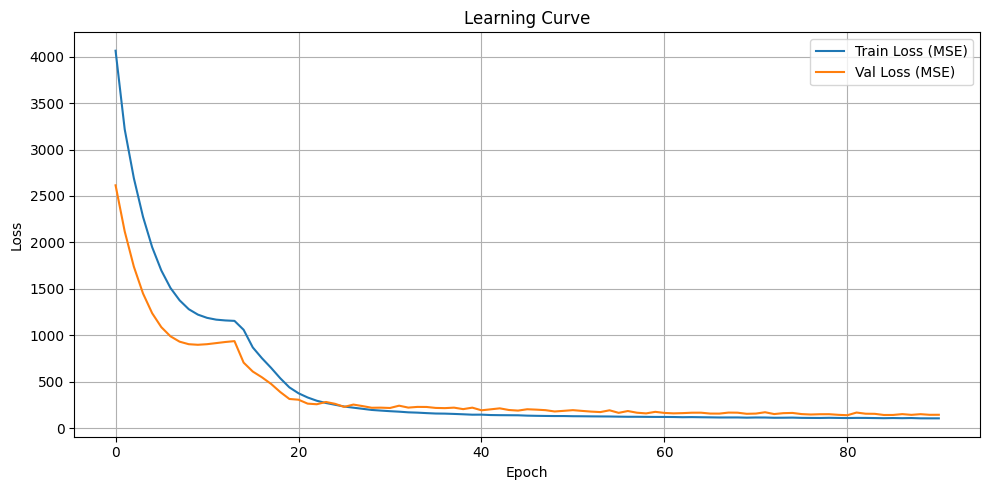

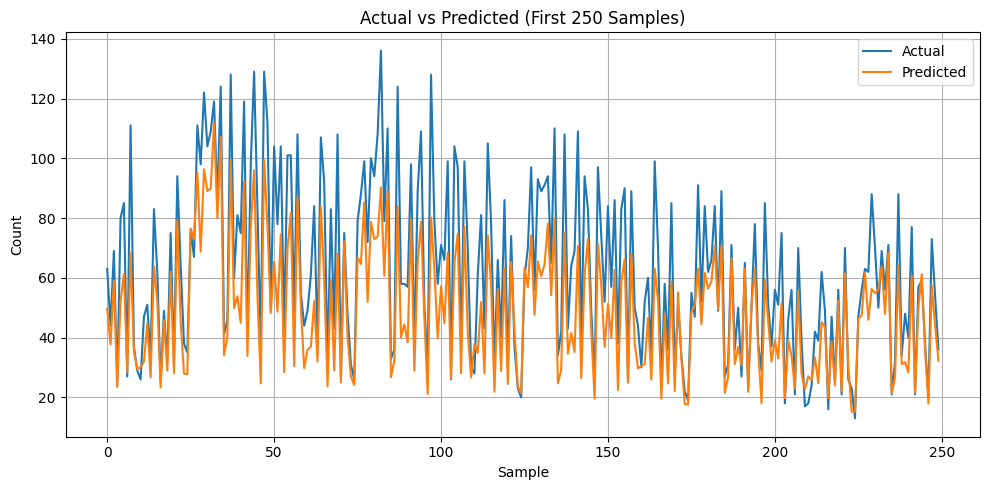

In [ ]:
# 🔮 Predict & Evaluate
y_pred = model.predict(X_test)

# Calculate metrics using original values
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mbe = np.mean(y_pred - y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print(f"\n📊 Evaluation Results:")
print(f"✅ MAPE  : {mape:.4f}")
print(f"✅ MSE  : {mse:.4f}")
print(f"✅ RMSE : {rmse:.4f}")
print(f"✅ MBE  : {mbe:.4f}")
print(f"✅ R²   : {r2:.4f}")

# 📈 Plot Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('learning_curve.png')
plt.show()

# 📊 Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test[:250], label='Actual')
plt.plot(y_pred[:250], label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Count')
plt.title('Actual vs Predicted (First 250 Samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('predictions_vs_actual.png')
plt.show()
